In [69]:
import os
import sys
import math
from functools import partial
# module_path = os.path.abspath(os.path.join('..'))
# if module_path not in sys.path:
#     sys.path.append(module_path)

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.layers import Input
from trowel import utils
import rasterio

from src.models import unet_2x, LFE, stacked_multi_scale, HED
from src.dataset import CustomImageDataGenerator
from src.config import *
from src.data import download_tile, decode_elevation
ELEVATION_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/high_ridge_terrain/Colorado/train/tif/sub'
MASK_TIF_DIR = '/Users/mikeskaug/Documents/personal/ridges/data/high_ridge_terrain/Colorado/train/mask/sub'

In [21]:
def load_subset(data_dir, N=None, frac=None, random=True, seed=1):
    '''
    Load a random subset of the images in a directory and return as an Nx256x256x1 numpy array
    '''
    np.random.seed(seed=seed)
    files = os.listdir(data_dir)
    if N:
        num_files = N
    elif frac:
        num_files = int(frac*len(files))
        
    if random:
        subset_files = np.random.choice(files, size=num_files, replace=False)
    else:
        subset_files = files[:num_files-1]
    
    data = []
    for fl in subset_files:
        im = Image.open(os.path.join(data_dir, fl))
        data.append(np.array(im))

    return np.expand_dims(np.stack(data), axis=3)

def standardize(featurewise_std, batch):
    batch -= batch.mean(axis=(1,2), keepdims=True)
    batch /= featurewise_std

    return batch

In [27]:
input_img = Input((*IMAGE_SIZE, 1), name='img')
model = HED(input_img)

In [28]:
# load weights
model.load_weights('/Users/mikeskaug/Documents/personal/ridges/output/checkpoint/2020-06-18T21:32/weights.20-0.07.hdf5')

In [6]:
# prepare image generators
validation_fraction = 0.05
batch_size = 8
subset = load_subset(ELEVATION_TIF_DIR, frac=0.2)
featurewise_std = subset.std()

files = os.listdir(ELEVATION_TIF_DIR)
np.random.shuffle(files)
train_files = files[:int(len(files)*(1-validation_fraction))]
validation_files = files[int(len(files)*(1-validation_fraction)):]

training_generator = CustomImageDataGenerator(
    ELEVATION_TIF_DIR, 
    MASK_TIF_DIR, 
    train_files, 
    batch_size=batch_size, 
    standardize_batch=partial(standardize, featurewise_std), 
    rescale_y=1/255,
    n_outputs=5
)

validation_generator = CustomImageDataGenerator(
    ELEVATION_TIF_DIR, 
    MASK_TIF_DIR, 
    validation_files, 
    batch_size=len(validation_files)*8, 
    standardize_batch=partial(standardize, featurewise_std), 
    rescale_y=1/255,
    n_outputs=5
)
validation_data = validation_generator.__getitem__(0)

In [7]:
# predict
N = 10
predict_batch = validation_data[0][:N,:,:,:]
masks = validation_data[1][0][:N,:,:,:]
predictions = model.predict_on_batch(predict_batch)


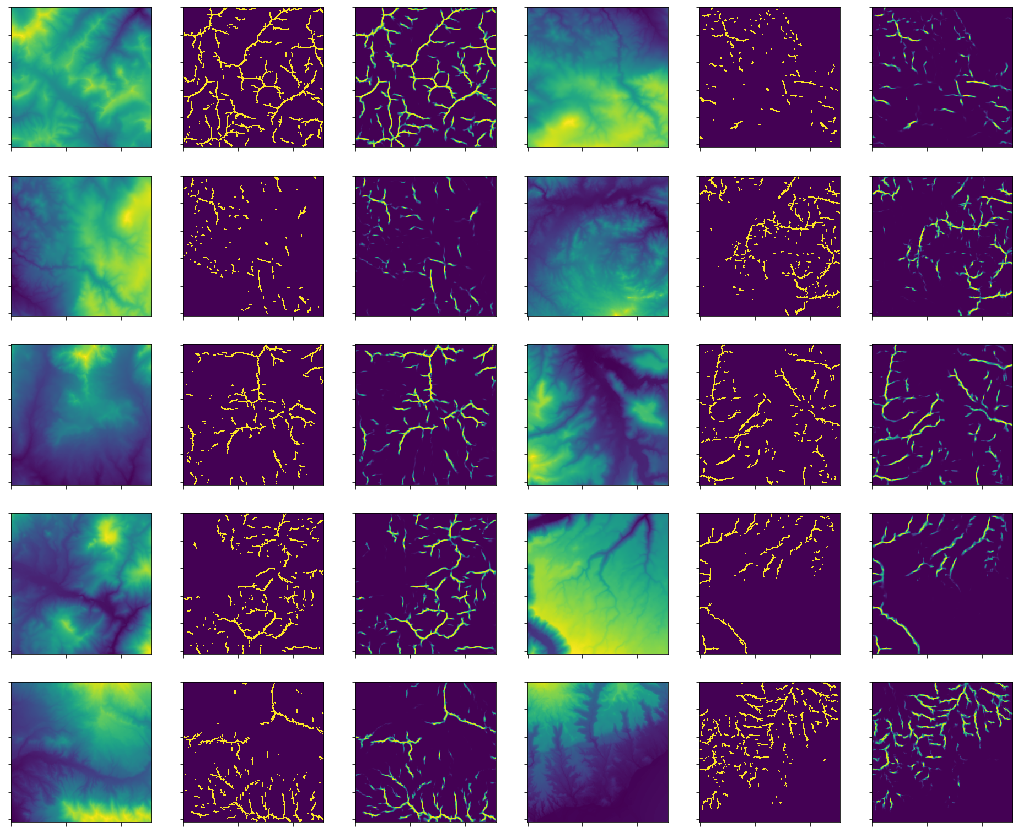

In [8]:
output = 4
all_images = np.empty((30,256,256,1), dtype=predictions[output].dtype)
all_images[0::3,:,:,:] = predict_batch
all_images[1::3,:,:,:] = masks
all_images[2::3,:,:,:] = predictions[output]

grid_width = 6
grid_height = int(all_images.shape[0] / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(18, 15))
for i in range(grid_height*grid_width):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow((all_images[i, :, :, :].reshape((256, 256))), cmap='viridis', ) #vmin=0, # coolwarm
    ax.set_yticklabels([])
    ax.set_xticklabels([])
#     ax.imshow(mask, alpha=0.3, cmap="Greens")
#     ax.imshow(pred, alpha=0.3, cmap="OrRd")

# Predict on large data set

In [112]:
# us_bounds = (-126.12, 24.60, -66.53, 49.26)
ca_nv_bounds = (-124.43, 35.83, -114.01, 41.96) # about 10000 tiles
ut_co_bounds = (-114.01, 35.83, -103.09, 41.96) # about 11000 tiles
tiles = utils.bbox_to_tiles(*ut_co_bounds, 12)

In [22]:
subset = load_subset(ELEVATION_TIF_DIR, frac=0.2)
featurewise_std = subset.std()
standardize_input = partial(standardize, featurewise_std)

In [115]:
for tile in tiles:
    url = os.path.join(TERRAIN_BASE_URL, str(tile[0]), str(tile[1]), str(tile[2])) + '.png'
    tile_img = download_tile(url)
    elevation = decode_elevation(np.array(tile_img))[np.newaxis,:,:,np.newaxis]
    ridges = np.squeeze(model.predict(standardize_input(elevation))[-1])

    output_bounds = rasterio.warp.transform_bounds('epsg:4326', 'epsg:3857', *utils.tile_bounds(tile[1], tile[2], tile[0]))
    transform = rasterio.transform.from_bounds(*output_bounds, ridges.shape[0], ridges.shape[1])
    with rasterio.open(
        f'../data/predictions/ut_and_co/{tile[0]}_{tile[1]}_{tile[2]}.tif',
        'w',
        driver='GTiff',
        height=ridges.shape[0],
        width=ridges.shape[1],
        count=1,
        dtype=ridges.dtype,
        crs='epsg:3857',
        transform=transform,
    ) as dst:
        dst.write(ridges, 1)

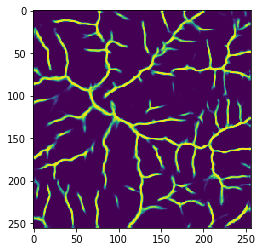

In [59]:
plt.imshow(np.squeeze(ridges))

# Merging into one geotif

Use [gdal_merge.py](https://gdal.org/programs/gdal_merge.html)

Run in a Docker container to avoid local install problems: [gdal image](https://github.com/OSGeo/gdal/tree/master/gdal/docker)

native tile pixel resolution = 38.218514

tile index extents:
x: 632 - 750 (119)
y: 1521 - 1610 (90)

pixel extent:
x: 119*256 = 30464
y: 90*256 = 23040

output pixel resolution = 152.874056

docker run -it -v /Users/mikeskaug/Documents/personal/ridges/data/predictions:/data/predictions osgeo/gdal:ubuntu-small-latest /bin/bash

$> gdal_merge.py -o merged.geotiff -ps 76.437028 76.437028 /data/predictions/ca_and_nv/*